# Рассмотрим файлы

Аналитика для компании — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy import stats as st

#изучим звонки<font color='brown'>В начале работы хорошо бы коротко описать наши данные и обрисовать цели.
calls = pd.read_csv('/datasets/calls.csv')

#сразу будем переводить все даты в формат дат
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(calls.head(10))
calls.info()
# здесь надо разобраться с длительностью звонков.

       id  call_date  duration  user_id
0  1000_0 2018-07-25      0.00     1000
1  1000_1 2018-08-17      0.00     1000
2  1000_2 2018-06-11      2.85     1000
3  1000_3 2018-09-21     13.80     1000
4  1000_4 2018-12-15      5.18     1000
5  1000_5 2018-11-02      0.00     1000
6  1000_6 2018-10-18      0.00     1000
7  1000_7 2018-08-22     18.31     1000
8  1000_8 2018-09-15     18.44     1000
9  1000_9 2018-08-15      0.00     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [57]:
print(calls['duration'].value_counts()) # нет значений нан или не нулевых 
# судя по информации из интернета мы делаем предположение что звонки с нулевым временем это недозвоны. 
# такие звонки тарифицируются как 1 минута разговора (https://www.iphones.ru/iNotes/539422). 
#(хотя правильно было бы уточнить у оператора условия их тарифов)

# сделаем столбик полных затраченных минут по тарифу.
calls['minutes']= (calls['duration']//1+1)
#переведем его в инт
calls['minutes'] = calls['minutes'].astype('int')

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64


<font color='green'>Молодец, что не забыл не только округлить, но и поменять тип.

In [58]:
internet = pd.read_csv('/datasets/internet.csv')
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()
internet['mb_used'] = internet['mb_used'].astype('int')
print(internet.head(10)) # тут все понятно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
       id  mb_used session_date  user_id
0  1000_0      112   2018-11-25     1000
1  1000_1     1052   2018-09-07     1000
2  1000_2     1197   2018-06-25     1000
3  1000_3      550   2018-08-22     1000
4  1000_4      302   2018-09-24     1000
5  1000_5      399   2018-10-02     1000
6  1000_6      540   2018-09-07     1000
7  1000_7      415   2018-07-11     1000
8  1000_8      505   2018-10-08     1000
9  1000_9      345   2018-09-03     1000


<s><font color='red'>А вот мегабайты округлить, похоже, забыл. Это не так критично, как с минутами, но все же.

In [59]:
#сообщения 
messages = pd.read_csv('/datasets/messages.csv')
messages['message_date']= pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

print(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


In [60]:
users = pd.read_csv('/datasets/users.csv')
users['reg_date']= pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date']= pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()
print(users.head())
# только 38 человек из 500 сменили тариф

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
   user_id  age churn_date         city first_name  last_name   reg_date  \
0     1000   52        NaT    Краснодар     Рафаил  Верещагин 2018-05-25   
1     1001   41        NaT       Москва       Иван       Ежов 2018-11-01   
2     1002   59        NaT  Стерлитамак    Евгений  Абрамович 2018-06-17   
3     1003   23        NaT       Москва      Белла   Белякова 2018-08-17   
4     1004   68        NaT  Новокузнецк    Татьяна   Авдеенко 2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  


In [61]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [62]:
#тарифы
tariffs = pd.read_csv('/datasets/tariffs.csv')
print(tariffs)

   messages_included  mg_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  


#### Мы рассмотрели данные, дополнили информацию по исопльзуемым минутам. Перевели даты в формат дат.

<font color='green'>Отлично, данные загружены и изучены. Найдены и устранены основные проблемы.

# Подготовка данных

In [63]:
#Посчитайте для каждого пользователя:
#количество сделанных звонков и израсходованных минут разговора по месяцам;

#выделим месяц в отдельный стобик
def needmonth(col):
    date = col['call_date']
    return date.month
calls['month'] = calls.apply(needmonth, axis=1)

calls_pivot = pd.pivot_table(calls, index = 'user_id',columns = 'month',values ='minutes', aggfunc = 'sum')

#print(calls_pivot.head(5))

<font color='blue'>Ооххх, здесь гораздо проще было через мультииндекс: index = ['user_id','month'], дальше в пару строк объединить таблицы и все. Но ты, я вижу, не ищешь легких путей ;)

In [64]:
# для удобства сделаем отдельный столбик в общей таблице пользователей с информацией по месяцам
calls_pivot['user_id'] = calls_pivot.index
def givemeaminute(col):
    user_id = col['user_id']
    if user_id in calls_pivot['user_id']:
        result = {a+1: calls_pivot.at[user_id, a+1] for a in range(12)}
        return(result)
    else:
        return {a+1: np.nan for a in range(12)}

users['minutes_used'] = users.apply(givemeaminute, axis=1) 
#print(users.head(10)) 

In [65]:
#теперь считаем количество сделанных звонков
calls_pivot_count = pd.pivot_table(calls, index = 'user_id',columns = 'month',values ='minutes', aggfunc = 'count')
#print(calls_pivot_count.head(5))
# и так же сохраним значения в таблицу с пользователями
calls_pivot_count['user_id'] = calls_pivot_count.index
def givemecount(col):
    user_id = col['user_id']
    if user_id in calls_pivot['user_id']:
        result = {a+1: calls_pivot_count.at[user_id, a+1] for a in range(12)}
        return(result)
    else:
        return {a+1: np.nan for a in range(12)}

users['calls_count'] = users.apply(givemecount, axis=1)


In [66]:
#количество отправленных сообщений по месяцам; все так же

def needmonthsms(col):
    date = col['message_date']
    return date.month

messages['month'] = messages.apply(needmonthsms, axis=1)
#print(messages.head())
messages_pivot = pd.pivot_table(messages, index = 'user_id', values = 'id',  columns = 'month', aggfunc = 'count')
messages_pivot['user_id'] = messages_pivot.index
#print(messages_pivot.head(5))

In [67]:
#добавляем в общую таблицу
def givemecountsms(col):
    user_id = col['user_id']
    if user_id in messages_pivot['user_id']:
        result = {a+1: messages_pivot.at[user_id, a+1] for a in range(12)}
        return(result)
    else:
        return {a+1: np.nan for a in range(12)}
    
users['message_count'] = users.apply(givemecountsms, axis=1)


In [68]:
# объем израсходннного по месяцам трафика
def needmonthinternet(col):
    date = col['session_date']
    return date.month

internet['month'] = internet.apply(needmonthinternet, axis=1)
#print(internet.head())
internet_pivot = pd.pivot_table(internet, index = 'user_id', values = 'mb_used',  columns = 'month', aggfunc = 'sum')
internet_pivot['user_id'] = internet_pivot.index
#print(internet_pivot.head(5))


In [69]:
#добавляем в общую таблицу
def givemeinternet(col):
    user_id = col['user_id']
    if user_id in internet_pivot['user_id']:
        result = {a+1: internet_pivot.at[user_id, a+1] for a in range(12)}
        return(result)
    else:
        return {a+1: np.nan for a in range(12)}
    
users['mb_used'] = users.apply(givemeinternet, axis=1)

In [70]:
print(users.head()) # хорошо

   user_id  age churn_date         city first_name  last_name   reg_date  \
0     1000   52        NaT    Краснодар     Рафаил  Верещагин 2018-05-25   
1     1001   41        NaT       Москва       Иван       Ежов 2018-11-01   
2     1002   59        NaT  Стерлитамак    Евгений  Абрамович 2018-06-17   
3     1003   23        NaT       Москва      Белла   Белякова 2018-08-17   
4     1004   68        NaT  Новокузнецк    Татьяна   Авдеенко 2018-05-14   

  tariff                                       minutes_used  \
0  ultra  {1: nan, 2: nan, 3: nan, 4: nan, 5: 164.0, 6: ...   
1  smart  {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: na...   
2  smart  {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: 11...   
3  ultra  {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: na...   
4  ultra  {1: nan, 2: nan, 3: nan, 4: nan, 5: 37.0, 6: 1...   

                                         calls_count  \
0  {1: nan, 2: nan, 3: nan, 4: nan, 5: 22.0, 6: 4...   
1  {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: na...

In [71]:
# считаем помесячную выручку с каждого пользователя. для этого напишем функции 
def money_on_minutes(minutes_used, tariff_name): # функция возвращает количество денег потраченных в месяц на лишних минутах
    result = minutes_used - tariffs[tariffs['tariff_name']== tariff_name].iat[0,2]
    if result <= 0:
        #print(0)
        return 0
    if result > 0:
        #print(result*tariffs[tariffs['tariff_name']== tariff_name].at[0,'rub_per_minute'])
        return result*tariffs[tariffs['tariff_name']== tariff_name].iat[0,6]
    else:
        #print(result)
        return result 

In [72]:
def money_on_messages(messages_count, tariff_name):# функция возвращает количество денег потраченных в месяц на лишних смс
    result = messages_count - tariffs[tariffs['tariff_name']== tariff_name].iat[0,0]
    if result <= 0:
        #print(0)
        return 0
    if result > 0:
        #print(result*tariffs[tariffs['tariff_name']== tariff_name].at[0,'rub_per_message'])
        return result*tariffs[tariffs['tariff_name']== tariff_name].iat[0,5]
    else:
        #print(result)
        return result    
    

In [73]:
def money_on_internet(mb_used, tariff_name): #возвращает количество денег потраченных на лишнем интернете
    result = mb_used - tariffs[tariffs['tariff_name']== tariff_name].iat[0,1]
    if result <= 0:
        #print(0)
        return 0
    if result > 0:
        #print((result// 1024+1) *  tariffs[tariffs['tariff_name']== tariff_name].at[0,'rub_per_gb'])
        return (result// 1024+1) *  tariffs[tariffs['tariff_name']== tariff_name].iat[0,4]
    else:
        #print(result)
        return result

In [74]:
def money_monthly(minutes_used,messages_count,mb_used,tariff_name):
    monthly_fee = tariffs[tariffs['tariff_name']== tariff_name].iat[0,3]
    internet_extra = money_on_internet(mb_used,tariff_name)
    sms_extra = money_on_messages(messages_count, tariff_name)
    minutes_extra = money_on_minutes(minutes_used, tariff_name)
    result = pd.Series([monthly_fee, internet_extra ,sms_extra , minutes_extra]) #по другому ошибка с нанами выходит.
    #print(result)
    
    return(result.sum())
#функция возвращает потречанное человеком количество денег за месяц    

<font color='green'>Молодец, что подтягиваешь тарифы напрямую из таблицы, а не используешь константы.

In [75]:
print(money_monthly(np.nan, 31423423, 232132, 'ultra')) #проверям что все норм работает

31453923.0


In [76]:
#теперь посчитаем по нашей таблице и добавим туда значения потраченных денег
def count_money(col):
    minutes_used = col['minutes_used']
    message_count = col['message_count']
    mb_used = col['mb_used']
    tariff = col['tariff']
    
    return  {a+1: money_monthly(minutes_used.get(a+1), message_count.get(a+1),mb_used.get(a+1),tariff) for a in range(12)}

In [77]:
users['money_spend'] = users.apply(count_money, axis=1)
# немножко долго делает но норм
print(users) #победа

     user_id  age churn_date         city first_name  last_name   reg_date  \
0       1000   52        NaT    Краснодар     Рафаил  Верещагин 2018-05-25   
1       1001   41        NaT       Москва       Иван       Ежов 2018-11-01   
2       1002   59        NaT  Стерлитамак    Евгений  Абрамович 2018-06-17   
3       1003   23        NaT       Москва      Белла   Белякова 2018-08-17   
4       1004   68        NaT  Новокузнецк    Татьяна   Авдеенко 2018-05-14   
..       ...  ...        ...          ...        ...        ...        ...   
495     1495   65        NaT      Иркутск  Авксентий      Фокин 2018-08-28   
496     1496   36        NaT      Вологда     Трифон     Блохин 2018-01-27   
497     1497   32        NaT    Челябинск   Каролина     Агеева 2018-10-09   
498     1498   68 2018-10-25  Владикавказ   Всеволод    Акимчин 2018-07-19   
499     1499   35        NaT        Пермь     Гектор   Корнилов 2018-09-27   

    tariff                                       minutes_used  

##Вывод. мы совместили данные в общей таблице вычеслив затраты каждого пользователя по месяцам, предварительно азписав в таблицу количество исопльзованных минут, смс, интернет трафика.

<font color='green'>Выбранный способ решения впечатляет.

# Анализ данных

In [78]:
#Опишите поведение клиентов оператора, исходя из выборки. 
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
def maketable(row, name):
    money_spend = row[name]
    result = []
    for i in range(12):
        result.append(money_spend.get(i))
    return(result)
        
    


In [79]:
internetdata = users.apply(maketable, name = 'mb_used' , axis=1,result_type='expand')

In [80]:
internetdata = internetdata.rename(columns ={i: i+1 for i in range(12)} ) # переименуем что бы месяца правильно шли
inetrnetdata2 = users.join(internetdata)

In [81]:
inetrnetdata_final = inetrnetdata2.iloc[:,[7,13,14,15,16,17,18,19,20,21,22,23,24]] # для наглядности оставим только нужные столбцы

In [82]:
inetrnetdata_final['sum']= inetrnetdata_final.sum(axis=1)
print(inetrnetdata_final)

    tariff   1       2        3        4        5        6        7        8  \
0    ultra NaN     NaN      NaN      NaN      NaN   2252.0  23213.0  13988.0   
1    smart NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2    smart NaN     NaN      NaN      NaN      NaN      NaN  10844.0  17557.0   
3    ultra NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4    ultra NaN     NaN      NaN      NaN      NaN  13392.0  17586.0  22211.0   
..     ...  ..     ...      ...      ...      ...      ...      ...      ...   
495  ultra NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
496  smart NaN  3756.0  28455.0  24924.0  21044.0  23676.0  20107.0  24338.0   
497  smart NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   
498  smart NaN     NaN      NaN      NaN      NaN      NaN      NaN   7469.0   
499  smart NaN     NaN      NaN      NaN      NaN      NaN      NaN      NaN   

           9       10       11       12

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
#ища среднее количество необходимых мегабайт нужно учитывать только те месяцы когда клиенты пользовались интернетом.
inetrnetdata_final['month_used'] = (inetrnetdata_final.count(axis =1) - 2)
inetrnetdata_final['mean'] = inetrnetdata_final['sum'] /inetrnetdata_final['month_used']
print(inetrnetdata_final.head())

  tariff   1   2   3   4   5        6        7        8        9       10  \
0  ultra NaN NaN NaN NaN NaN   2252.0  23213.0  13988.0  14043.0  14556.0   
1  smart NaN NaN NaN NaN NaN      NaN      NaN      NaN      NaN      NaN   
2  smart NaN NaN NaN NaN NaN      NaN  10844.0  17557.0  20298.0  16669.0   
3  ultra NaN NaN NaN NaN NaN      NaN      NaN      NaN   8557.0  12457.0   
4  ultra NaN NaN NaN NaN NaN  13392.0  17586.0  22211.0  28558.0  15093.0   

        11       12       sum  month_used          mean  
0  14690.0  14745.0   97487.0           7  13926.714286  
1      NaN  18405.0   18405.0           1  18405.000000  
2  13869.0  18566.0   97803.0           6  16300.500000  
3  14754.0  11348.0   47116.0           4  11779.000000  
4  18457.0  15598.0  130895.0           7  18699.285714  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
# находим средние значения
print(inetrnetdata_final['mean'].mean()) # общее среднее 
print(inetrnetdata_final[inetrnetdata_final['tariff']=='smart']['mean'].mean()) # для тарифа смарт
print(inetrnetdata_final[inetrnetdata_final['tariff']=='ultra']['mean'].mean()) # для тарифа ультра

16243.820537136251
15247.336569587962
18542.851405122656


In [85]:
#посомтрим дисперсию общую
internet_var = np.var(inetrnetdata_final['mean'], ddof = 1)
print(internet_var) # дисперсия
print(np.sqrt(internet_var)) # стандартное отклонение

33351182.89665664
5775.048302538831


In [86]:
# для разных тарифов
smart_var = np.var(inetrnetdata_final[inetrnetdata_final['tariff']=='smart']['mean'],ddof = 1)
print(smart_var, 'дисперсия тарифа смарт')
print(np.sqrt(smart_var), 'стандартное отклонение для тарифа смарт')
print()
ultra_var = np.var(inetrnetdata_final[inetrnetdata_final['tariff']=='ultra']['mean'],ddof = 1)
print(ultra_var, 'дисперсия тарифа ультра')
print(np.sqrt(ultra_var), 'стандартное отклонение для тарифа ультра')

16150126.378697265 дисперсия тарифа смарт
4018.7219832550327 стандартное отклонение для тарифа смарт

65807173.796565846 дисперсия тарифа ультра
8112.162091364166 стандартное отклонение для тарифа ультра


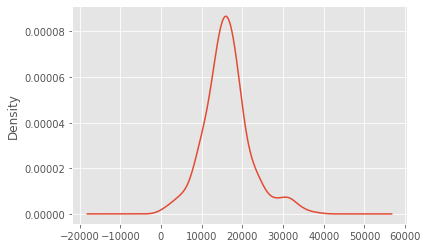

In [87]:
inetrnetdata_final['mean'].plot.kde() #плотность респределения

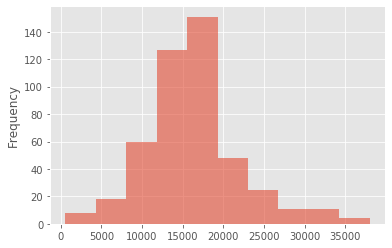

In [88]:
inetrnetdata_final['mean'].plot.hist(alpha=0.6) #гистограмма общая

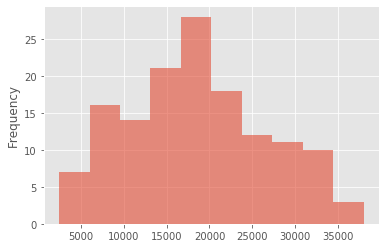

In [89]:
#гистаграмма для тарифа ультра
inetrnetdata_final[inetrnetdata_final['tariff']=='ultra']['mean'].plot.hist(alpha=0.6)

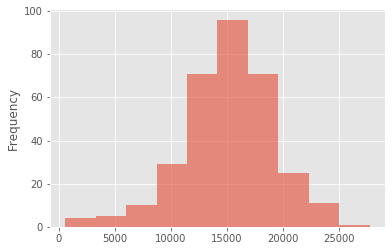

In [90]:
#гистаграмма для тарифа смарт
inetrnetdata_final[inetrnetdata_final['tariff']=='smart']['mean'].plot.hist(alpha=0.6)

#### Таким образом количество затраченных мб для пользователей тарифа смарт нормально распределены вокруг значения в 16.5 тысяч мегабайт в месяц. Для пользвоателей тарифа среднее значение чуть выше, но главное они распределены менее равномерно - чаще тратят либо больше мегобайт либо значительно меньше. Вероятно часть пользователей дорогого тарифа действительно нуждается в большем обьеме трафика, а часть покупают его просто потому что могут.

In [91]:
# теперь эту же процедуру надо выполнить для количества минут
minut_data = users.apply(maketable, name = 'minutes_used' , axis=1,result_type='expand')

minut_data = minut_data.rename(columns ={i: i+1 for i in range(12)} ) # переименуем что бы месяца правильно шли
minut_data2 = users.join(minut_data)
minut_data_final = minut_data2.iloc[:,[7,13,14,15,16,17,18,19,20,21,22,23,24]] # для наглядности оставим только нужные столбцы
#print(minut_data_final)

minut_data_final['sum']= minut_data_final.sum(axis=1)

minut_data_final['month_used'] = (minut_data_final.count(axis =1) - 2)
minut_data_final['mean'] = minut_data_final['sum'] /minut_data_final['month_used']
print(minut_data_final.head())

  tariff   1   2   3   4   5      6      7      8      9     10     11     12  \
0  ultra NaN NaN NaN NaN NaN  164.0  187.0  346.0  419.0  479.0  363.0  344.0   
1  smart NaN NaN NaN NaN NaN    NaN    NaN    NaN    NaN    NaN    NaN  444.0   
2  smart NaN NaN NaN NaN NaN    NaN  118.0  219.0  296.0  218.0  221.0  250.0   
3  ultra NaN NaN NaN NaN NaN    NaN    NaN    NaN  392.0  990.0  867.0  844.0   
4  ultra NaN NaN NaN NaN NaN   37.0  177.0  137.0  138.0  125.0  154.0  122.0   

      sum  month_used        mean  
0  2302.0           7  328.857143  
1   444.0           1  444.000000  
2  1322.0           6  220.333333  
3  3093.0           4  773.250000  
4   890.0           7  127.142857  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [92]:
# находим средние значения
print(minut_data_final['mean'].mean(), 'общее среднее') # общее среднее 
print(minut_data_final[minut_data_final['tariff']=='smart']['mean'].mean(), 'среднее по смарт') # для тарифа смарт
print(minut_data_final[minut_data_final['tariff']=='ultra']['mean'].mean(), 'среднне по ультра') # для тарифа ультра
print()
#посомтрим дисперсию общую
minuts_var = np.var(minut_data_final['mean'], ddof = 1)
print(minuts_var, ' общая дисперсия') # дисперсия
print(np.sqrt(minuts_var), ' общее стандартное отклонение') # стандартное отклонение
print()
# для разных тарифов
smart_var = np.var(minut_data_final[minut_data_final['tariff']=='smart']['mean'],ddof = 1)
print(smart_var, 'дисперсия тарифа смарт')
print(np.sqrt(smart_var), 'стандартное отклонение для тарифа смарт')
print()
ultra_var = np.var(minut_data_final[minut_data_final['tariff']=='ultra']['mean'],ddof = 1)
print(ultra_var, 'дисперсия тарифа ультра')
print(np.sqrt(ultra_var), 'стандартное отклонение для тарифа ультра')

441.90541188554295 общее среднее
405.97382924184166 среднее по смарт
526.9787178507767 среднне по ультра

40042.82191848618  общая дисперсия
200.1070261597183  общее стандартное отклонение

22056.173690296815 дисперсия тарифа смарт
148.5132104908409 стандартное отклонение для тарифа смарт

72737.14798623852 дисперсия тарифа ультра
269.698253583961 стандартное отклонение для тарифа ультра


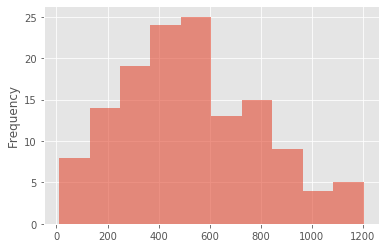

In [93]:
#гистаграмма для тарифа ультра
minut_data_final[minut_data_final['tariff']=='ultra']['mean'].plot.hist(alpha=0.6)

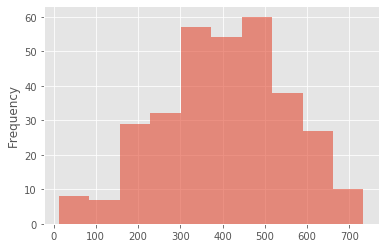

In [94]:
#для тарифа смарт
minut_data_final[minut_data_final['tariff']=='smart']['mean'].plot.hist(alpha=0.6)

#### гистограмма затраченных минут пользователей тарифа ультра распределена вокруг 500 минут в месяц и смещена влево. В то же время пользователи тарифа смарт распредлены вокруг 450 минут с небольшим смещение вправо.

In [95]:
# анализируем смс
sms_data = users.apply(maketable, name = 'message_count' , axis=1,result_type='expand')

sms_data = sms_data.rename(columns ={i: i+1 for i in range(12)} ) # переименуем что бы месяца правильно шли
sms_data2 = users.join(sms_data)
sms_data_final = sms_data2.iloc[:,[7,13,14,15,16,17,18,19,20,21,22,23,24]] # для наглядности оставим только нужные столбцы

sms_data_final['sum']= sms_data_final.sum(axis=1)

sms_data_final['month_used'] = (sms_data_final.count(axis =1) - 2)
sms_data_final['mean'] = sms_data_final['sum'] /sms_data_final['month_used']
print(sms_data_final.head())

  tariff   1   2   3   4   5     6      7      8      9     10     11     12  \
0  ultra NaN NaN NaN NaN NaN  22.0   60.0   75.0   81.0   57.0   73.0   58.0   
1  smart NaN NaN NaN NaN NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2  smart NaN NaN NaN NaN NaN   NaN    4.0   11.0   13.0    4.0   10.0   16.0   
3  ultra NaN NaN NaN NaN NaN   NaN    NaN    NaN   37.0   91.0   83.0   94.0   
4  ultra NaN NaN NaN NaN NaN  95.0  134.0  181.0  151.0  146.0  165.0  158.0   

      sum  month_used        mean  
0   426.0           7   60.857143  
1     0.0           0         NaN  
2    58.0           6    9.666667  
3   305.0           4   76.250000  
4  1030.0           7  147.142857  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [96]:
# находим средние значения
print(sms_data_final['mean'].mean(), 'общее среднее') # общее среднее 
print(sms_data_final[sms_data_final['tariff']=='smart']['mean'].mean(), 'среднее по смарт') # для тарифа смарт
print(sms_data_final[sms_data_final['tariff']=='ultra']['mean'].mean(), 'среднне по ультра') # для тарифа ультра
print()
#посомтрим дисперсию общую
sms_var = np.var(sms_data_final['mean'], ddof = 1)
print(sms_var, ' общая дисперсия') # дисперсия
print(np.sqrt(sms_var), ' общее стандартное отклонение') # стандартное отклонение
print()
# для разных тарифов
smart_var = np.var(sms_data_final[sms_data_final['tariff']=='smart']['mean'],ddof = 1)
print(smart_var, 'дисперсия тарифа смарт')
print(np.sqrt(smart_var), 'стандартное отклонение для тарифа смарт')
print()
ultra_var = np.var(sms_data_final[sms_data_final['tariff']=='ultra']['mean'],ddof = 1)
print(ultra_var, 'дисперсия тарифа ультра')
print(np.sqrt(ultra_var), 'стандартное отклонение для тарифа ультра')

43.66812263685682 общее среднее
36.224715176520235 среднее по смарт
61.14120625137574 среднне по ультра

1082.253164944007  общая дисперсия
32.89761640216517  общее стандартное отклонение

585.2447529880312 дисперсия тарифа смарт
24.191832361109633 стандартное отклонение для тарифа смарт

1824.844266626847 дисперсия тарифа ультра
42.71819596643621 стандартное отклонение для тарифа ультра


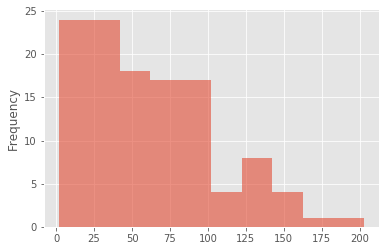

In [97]:
sms_data_final[sms_data_final['tariff']=='ultra']['mean'].plot.hist(alpha=0.6) #гистаграмма для ультра

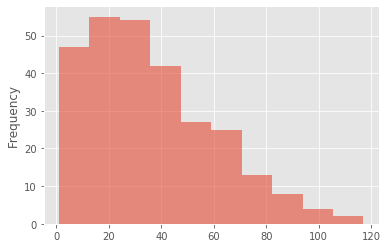

In [98]:
sms_data_final[sms_data_final['tariff']=='smart']['mean'].plot.hist(alpha=0.6) #гистаграмма для смарт

In [99]:
# посчитаем деньги
money_data = users.apply(maketable, name = 'money_spend' , axis=1,result_type='expand')

money_data = money_data.rename(columns ={i: i+1 for i in range(12)} ) # переименуем что бы месяца правильно шли
money_data2 = users.join(money_data)
money_data_final = money_data2.iloc[:,[7,13,14,15,16,17,18,19,20,21,22,23,24]] # для наглядности оставим только нужные столбцы
#print(minut_data_final)

money_data_final['sum']= money_data_final.sum(axis=1)

money_data_final['month_used'] = (money_data_final.count(axis =1) - 2)
money_data_final['mean'] = money_data_final['sum'] /money_data_final['month_used']
#print(money_data_final.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [100]:
# находим средние значения
print(money_data_final['mean'].mean(), 'общее среднее') # общее среднее 
print(money_data_final[money_data_final['tariff']=='smart']['mean'].mean(), 'среднее по смарт') # для тарифа смарт
print(money_data_final[money_data_final['tariff']=='ultra']['mean'].mean(), 'среднне по ультра') # для тарифа ультра
print()
#посомтрим дисперсию общую
money_var = np.var(money_data_final['mean'], ddof = 1)
print(money_var, ' общая дисперсия') # дисперсия
print(np.sqrt(money_var), ' общее стандартное отклонение') # стандартное отклонение
print()
# для разных тарифов
money_var = np.var(money_data_final[money_data_final['tariff']=='smart']['mean'],ddof = 1)
print(smart_var, 'дисперсия тарифа смарт')
print(np.sqrt(smart_var), 'стандартное отклонение для тарифа смарт')
print()
ultra_var = np.var(money_data_final[money_data_final['tariff']=='ultra']['mean'],ddof = 1)
print(ultra_var, 'дисперсия тарифа ультра')
print(np.sqrt(ultra_var), 'стандартное отклонение для тарифа ультра')

1225.2974545454547 общее среднее
893.9616679616678 среднее по смарт
2005.8267236119582 среднне по ультра

353916.018831183  общая дисперсия
594.9084121368456  общее стандартное отклонение

585.2447529880312 дисперсия тарифа смарт
24.191832361109633 стандартное отклонение для тарифа смарт

21377.61909116393 дисперсия тарифа ультра
146.21087200055928 стандартное отклонение для тарифа ультра


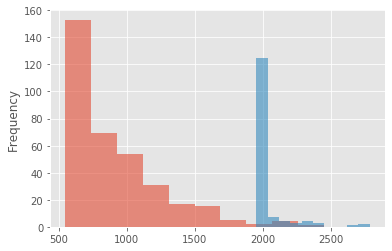

In [101]:
money_data_final[money_data_final['tariff']=='smart']['mean'].plot.hist(alpha=0.6)
money_data_final[money_data_final['tariff']=='ultra']['mean'].plot.hist(alpha=0.6)

In [102]:
#как часто привышают лимиты
total_smart = money_data_final.query(' tariff == "smart"')['mean'].count() 
smart_over =  money_data_final.query(' (tariff == "smart") &(mean != 550)')['mean'].count()
total_ultra = money_data_final.query(' tariff == "ultra"')['mean'].count() 
ultra_over = money_data_final.query(' (tariff == "ultra") &(mean != 1950)')['mean'].count()

print(smart_over/total_smart , '% пользователей смарт привышают лимит')
print(ultra_over/total_ultra, '% пользователей ультра привышают лимит' )

0.8404558404558404 % пользователей смарт привышают лимит
0.2483221476510067 % пользователей ультра привышают лимит


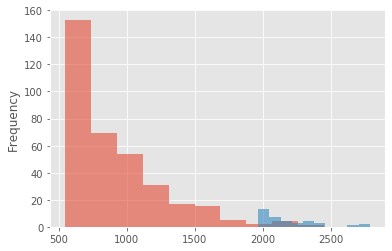

In [103]:
#привышения лимитов
money_data_final.query(' (tariff == "smart") &(mean != 650)')['mean'].plot.hist(alpha=0.6)
money_data_final.query(' (tariff == "ultra") &(mean != 1950)')['mean'].plot.hist(alpha=0.6)

#### В среднем пользователи ультры отрпаляют больше смсок, хотя обе гистограммы смещены влево и распредлены вокург небольших значений (20 смс в месяц для ссмарт и около 30 для ультра). В ультре сильно представлен сегмент в 50-100 сообщений, в то время как для смарт он идет по естественной ниспадающей.

В среднем пользователи ультра траят более чем в два раза больше средств. (2005рубля , против 893рублей) Несмотря на то, что разброс затрат у тарифа ультра больше, его пользователи гораздо реже выходят из лимита и платят сверх абонентской платы. В среднем пользвоатели ултра тратят примерно на 3гб и на 100 минут больше чем пользователи смарта. В смарте 84% так или иначе привышают лимит и тратят дополнительные срдства, в то время как в ультре таких только 24%.

# Проверка гипотез

In [104]:
#средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
#средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
#Пороговое значение alpha задайте самостоятельно.
#Поясните:
#как вы формулировали нулевую и альтернативную гипотезы;
#какой критерий использовали для проверки гипотез и почему.

In [105]:
#средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

money_data = users.apply(maketable, name = 'money_spend' , axis=1,result_type='expand')

money_data = money_data.rename(columns ={i: i+1 for i in range(12)} ) # переименуем что бы месяца правильно шли
money_data2 = users.join(money_data)
money_data_final = money_data2.iloc[:,[7,13,14,15,16,17,18,19,20,21,22,23,24]] # для наглядности оставим только нужные столбцы

money_data_final['sum']= money_data_final.sum(axis=1)

money_data_final['month_used'] = (money_data_final.count(axis =1) - 2)
money_data_final['mean'] = money_data_final['sum'] /money_data_final['month_used']
print(money_data_final.head())

  tariff   1       2       3       4       5       6       7       8       9  \
0  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   
1  smart NaN   550.0   550.0   550.0   550.0   550.0   550.0   550.0   550.0   
2  smart NaN   550.0   550.0   550.0   550.0   550.0   550.0  1150.0  1550.0   
3  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   
4  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   

       10      11      12      sum  month_used         mean  
0  1950.0  1950.0  1950.0  21450.0          11  1950.000000  
1   550.0   550.0  1150.0   6650.0          11   604.545455  
2   950.0   550.0  1350.0   8850.0          11   804.545455  
3  1950.0  1950.0  1950.0  21450.0          11  1950.000000  
4  1950.0  1950.0  1950.0  21450.0          11  1950.000000  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [111]:
# нулевая гипотеза: Средняя выручка для смарт и ультра одинаковые. 
#альтерантиваня гипотеза:Средняя выручка для cмарт и ультра различаются 
alpha = 0.05

ultra_money = money_data_final[money_data_final['tariff']== 'ultra']['mean'] #выборка по ультра
smart_money = money_data_final[money_data_final['tariff']== 'smart']['mean'] #выборка по смарт

result = st.ttest_ind(
    ultra_money, 
    smart_money)

print(result.pvalue, 'pvalue')

if alpha  < result.pvalue :
    print('Нулевая гипотеза подтверждена. Средняя выручка для смарт и ультра одинаковые')
else:
    print('Нулевая гипотеза не потверждена. Принимаем альтерантивную : Средняя выручка для смарт и ультра различаются')
    
    
    
## чем меньше p-value тем меньше шанс принять нулевую гипотезу.
#В данном случае p-value меньше назначенных нами 5%, значит нулевая гпиотеза отвергается.
# не понимаю где тут ошибка

1.4038345058140396e-144 pvalue
Нулевая гипотеза не потверждена. Принимаем альтерантивную : Средняя выручка для смарт и ультра различаются


In [107]:
#средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
#тут может получится перекос из-за пользователей ультра. поэому стоит разобрать тарифы по отдельности
money_data_final_regions = money_data2.iloc[:,[3,7,13,14,15,16,17,18,19,20,21,22,23,24]]

money_data_final_regions['sum']= money_data_final_regions.sum(axis=1)

money_data_final_regions['month_used'] = (money_data_final_regions.count(axis =1) - 3)
money_data_final_regions['mean'] = money_data_final_regions['sum'] /money_data_final_regions['month_used']
print(money_data_final_regions.head())


ultra_money_moscow = money_data_final_regions[(money_data_final_regions['tariff']== 'ultra')&(money_data_final_regions['city']== 'Москва')]['mean'] #выборка по ультра Москва
ultra_money_regions = money_data_final_regions[(money_data_final_regions['tariff']== 'ultra')&(money_data_final_regions['city']!= 'Москва')]['mean'] #выборка по ультра регионы

smart_money_moscow = money_data_final_regions[(money_data_final_regions['tariff']== 'smart')&(money_data_final_regions['city']== 'Москва')]['mean'] #выборка по ультра Москва
smart_money_regions = money_data_final_regions[(money_data_final_regions['tariff']== 'smart')&(money_data_final_regions['city']!= 'Москва')]['mean'] #выборка по ультра регионы

#smart_money = money_data_final_regions[money_data_final_regions['tariff']== 'smart']['mean'].tolist() #выборка по смарт

          city tariff   1       2       3       4       5       6       7  \
0    Краснодар  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   
1       Москва  smart NaN   550.0   550.0   550.0   550.0   550.0   550.0   
2  Стерлитамак  smart NaN   550.0   550.0   550.0   550.0   550.0   550.0   
3       Москва  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   
4  Новокузнецк  ultra NaN  1950.0  1950.0  1950.0  1950.0  1950.0  1950.0   

        8       9      10      11      12      sum  month_used         mean  
0  1950.0  1950.0  1950.0  1950.0  1950.0  21450.0          11  1950.000000  
1   550.0   550.0   550.0   550.0  1150.0   6650.0          11   604.545455  
2  1150.0  1550.0   950.0   550.0  1350.0   8850.0          11   804.545455  
3  1950.0  1950.0  1950.0  1950.0  1950.0  21450.0          11  1950.000000  
4  1950.0  1950.0  1950.0  1950.0  1950.0  21450.0          11  1950.000000  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [108]:
#проверяем нулевую гипотезу: средняя выручка пользователей УЛЬТРА из Москвы и регионов одинаковая;
#альтерантивная гипотеза: Средняя выручка ультра для Москвы отличается от выручки пользователей из других регионов
alpha = 0.05
result = st.ttest_ind(
    ultra_money_moscow, 
    ultra_money_regions)

print(result.pvalue, 'pvalue')

if alpha < result.pvalue :
    print('Нулевая гипотеза подтверждена. Средняя выручка ультра для Москвы и регионов одинаковая')
else:
    print('Нулевая гипотеза не потверждена.Принимаем альтерантивную:  выручка от пользовальтелей ультра в Москве и регионах разная')
    
    
# pvalue = 0.7, значит выборки по Москве и регионам вобще почти идентичны

0.7112444187323743 pvalue
Нулевая гипотеза подтверждена. Средняя выручка ультра для Москвы и регионов одинаковая


<font color='brown'>Здесь и ниже более корректно было бы написать "не удалось отвергнуть нулевую гипотезу".

In [109]:
#проверяем нулевую гипотезу: средняя выручка пользователей СМАРТ из Москвы и регионов одинаковая;
#альтернативная гипотеза: Средняя выручка смарт для Москвы и регионов различается
alpha = 0.05
result = st.ttest_ind(
    smart_money_moscow, 
    smart_money_regions)

print(result.pvalue, 'pvalue')

if alpha <result.pvalue :
    print('Нулеваяя гипотеза подтверждена. Средняя выручка смарт для Москвы и регионов одинаковая')
else:
    print('Нулевая гипотеза не потверждена. Принимаем альтерантивную: выручка  от пользовальтелей смарт в Москве и регионах разная')
    

0.1457286949382275 pvalue
Нулеваяя гипотеза подтверждена. Средняя выручка смарт для Москвы и регионов одинаковая


In [110]:
#проверяем гипотезу: средняя выручка от пользователя из Москвы НЕ отличается от выручки пользователей из других регионов;
#альтерантивная гипотеза: Средняя выручка для Москвы и регионов разная

total_money_moscow = money_data_final_regions[money_data_final_regions['city']== 'Москва']['mean'] #выборка по ультра Москва
total_money_regions = money_data_final_regions[money_data_final_regions['city']!= 'Москва']['mean'] #выборка по ультра регионы

result = st.ttest_ind(
    total_money_moscow, 
    total_money_regions)

print(result.pvalue, 'pvalue')

if alpha <result.pvalue :
    print('Нулевая гипотеза подтверждена. Средняя выручка для Москвы и регионов одинаковая')
else:
    print('Нулевая гипотеза не потверждена. Принимаем альтерантивную:  выручка  от пользовальтелей в Москве и регионах разная')
    
# таким образом даже разное коилчество пользователей ультра в Москве и регионах не повлияло на вывод

0.886790087557315 pvalue
Нулевая гипотеза подтверждена. Средняя выручка для Москвы и регионов одинаковая


# Вывод

#### Мы изучили предоставленные данные, дополнили где это было необходимо и свели их в общую удобную таблицу.  Построили гистаграммы по затраченным минутам, смскам, и мегабайтам ежемесячно для пользователей каждого тарифа, почитали дисперсию и нормальное отклонение. Проанализировав графики выяснили различие в поведении пользвателей тарифов. Пользователи Смарт в основном распределены нормально, в то время как польовальтели Ультра чаще смещены в пользу значительно большего и меньшего потребления услуг. Вероятно это связанно с тем, что часть пользовальтелей Ультры выбрали этот тариф по объективным соображениям из-за высоких потребностей, а часть просто взяла полный безлимит что бы не думать о связи, хотя им хватило бы и меньшего тарифа.
#### Подтвердилась гипотеза о том, что средняя выручка от пользователей в Москве и регионах принципиально не отличается. В то же время выручка от пользователей разных тарифов отличается сильно.